# Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

<h3 data-start="0" data-end="403"><em><strong>Objetivo:</strong></em></h3>
<p data-start="0" data-end="403">Desarrollar un modelo de red neuronal artificial capaz de detectar transacciones fraudulentas en tarjetas de cr&eacute;dito, utilizando un conjunto de datos altamente desbalanceado, donde las variables predictoras han sido transformadas mediante PCA. El modelo buscar&aacute; maximizar la detecci&oacute;n de fraudes (clase 1) manteniendo un alto desempe&ntilde;o general, a pesar del bajo porcentaje de casos positivos.</p>

### Imports

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
import random
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score , classification_report
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score


In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Semillas

In [21]:
# 1. Semilla para Python
random.seed(42)
# 2. Semilla para NumPy
np.random.seed(42)
# 3. Semilla para TensorFlow
tf.random.set_seed(42)

### Funciones auxiliares

In [22]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [23]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [24]:
def find_best_threshold(y_true, y_probs, metric=f1_score):
    best_threshold = 0.5
    best_metric = 0

    thresholds = np.linspace(0, 1, 100)
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = metric(y_true, y_pred)
        if score > best_metric:
            best_metric = score
            best_threshold = t

    return best_threshold, best_metric

## 1. Lectura del conjunto de datos

In [25]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

## 2. Visualización del conjunto de datos

In [26]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [27]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


<p><em><strong>Comentario:</strong> El dataset por motivos de seguridad se le ha aplicado el algoritmo PCA, ya est&aacute; normalizado con excepci&oacute;n de dos columnas que son tiempo y Amount.&nbsp;</em></p>

In [28]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

<p><em><strong>Comentario:</strong> Las clases est&aacute;n sumamente desbalanceadas, la clase 1 es el 0.1730 % del Dataset, por lo cual probablemente usemos un muestreo estratificado m&aacute;s adelante.</em></p>

In [29]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [30]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [31]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<p><em><strong>Comentario:</strong> No hay valores nulos o faltantes, y todas las variables con las excepciones mencionadas m&aacute;s arriba est&aacute;n en los mismos rangos.&nbsp;</em></p>

### Visualizaciones Preliminares

/tmp/ipykernel_35/2808278915.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


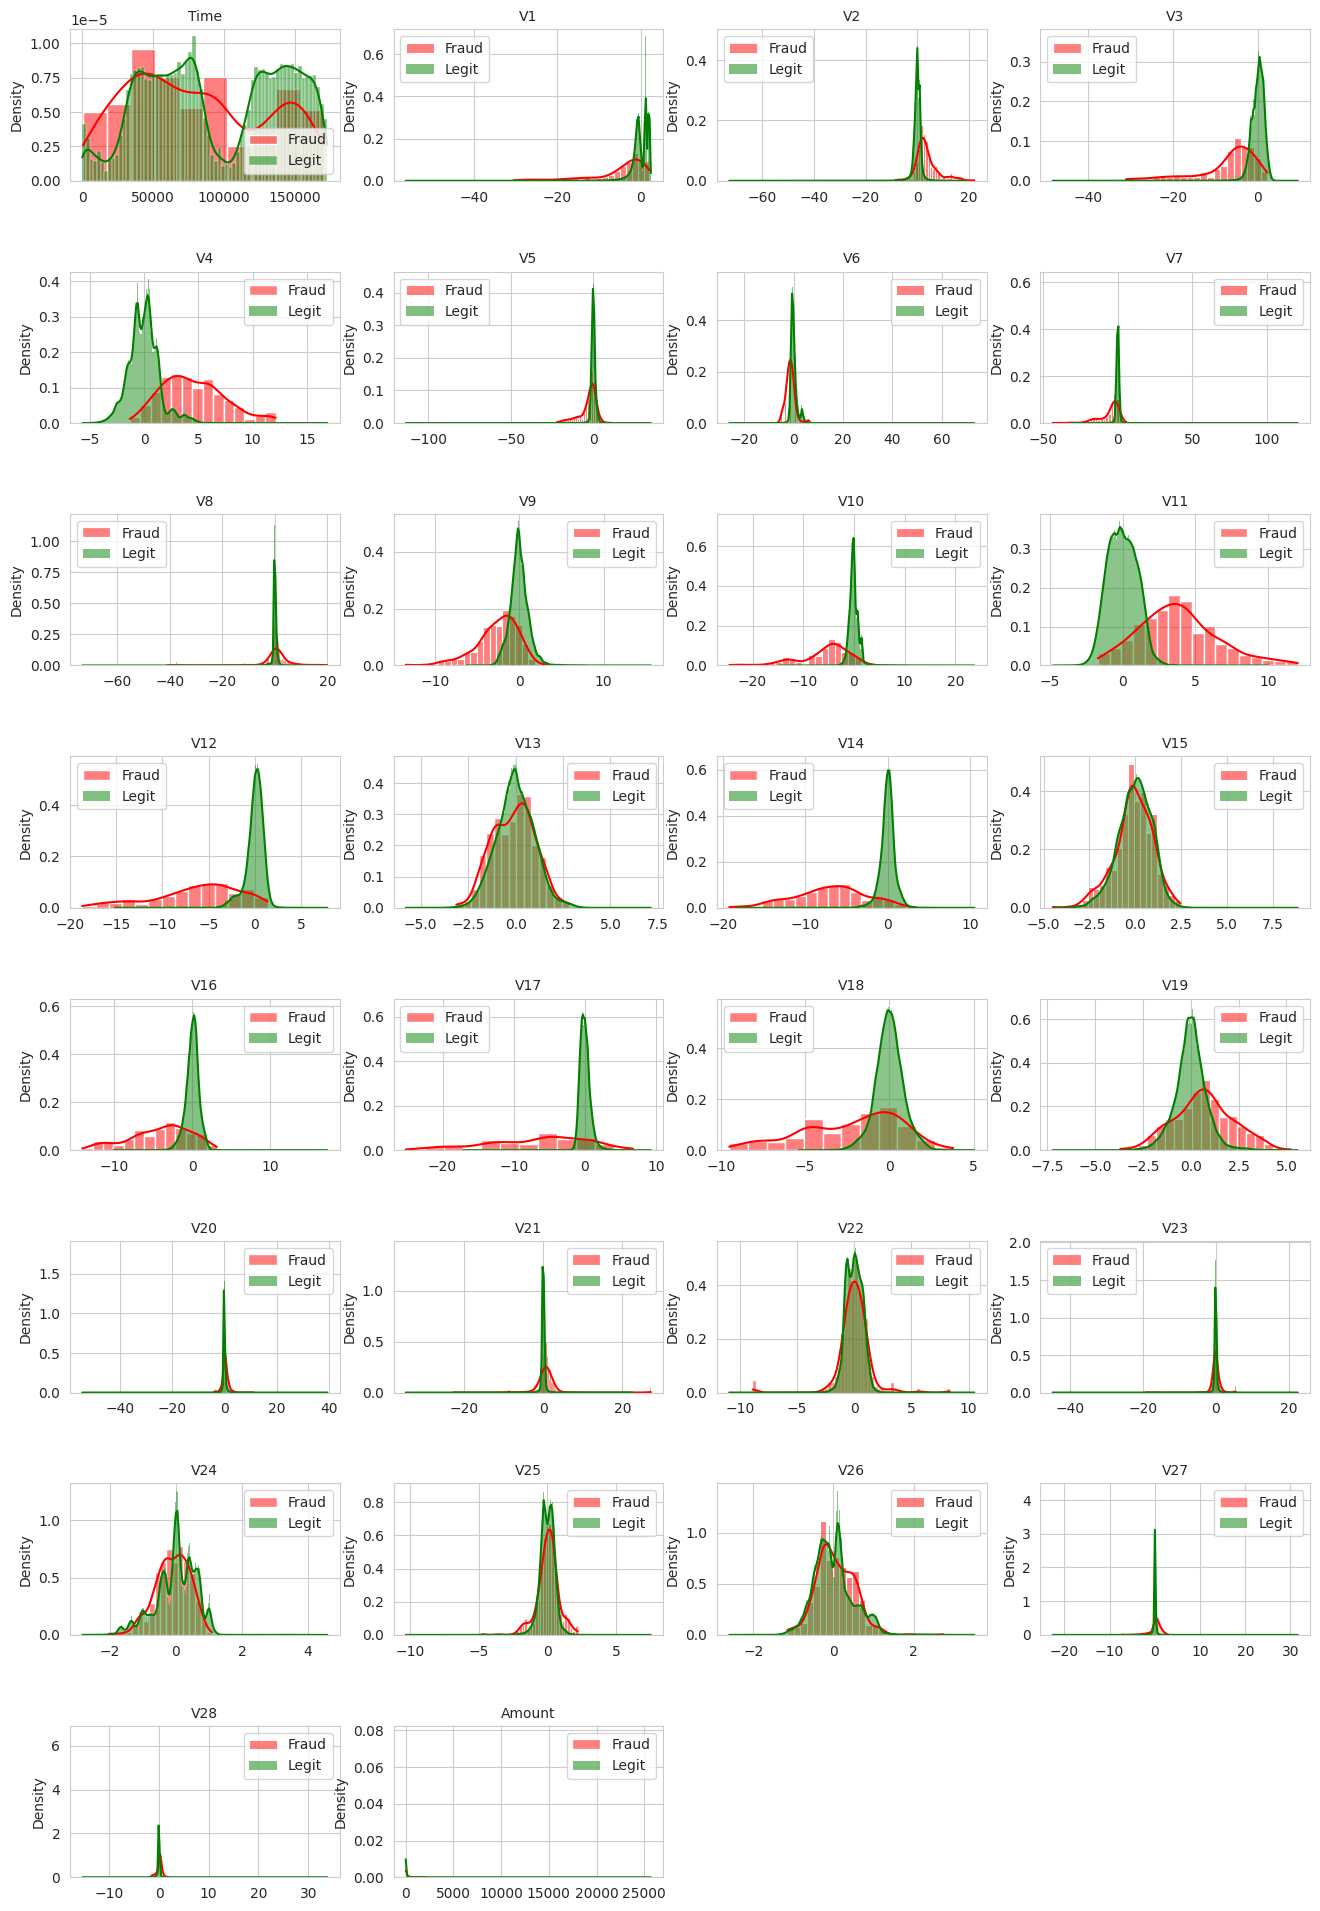

In [32]:
# Definimos solo las variables predictoras
features = df.drop("Class", axis=1).columns
n_features = len(features)

# Calculamos tamaño óptimo de la grilla (por ejemplo, 4 columnas)
cols = 4
rows = int(np.ceil(n_features / cols))

# Estilo general
sns.set_style("whitegrid")
plt.figure(figsize=(cols * 4, rows * 3))
gs = gridspec.GridSpec(rows, cols)
gs.update(hspace=0.6)

# Recorremos cada variable
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Histograma para fraude (Class==1)
    sns.histplot(df[df["Class"] == 1][f], kde=True, stat="density", color="red", alpha=0.5, label="Fraud", ax=ax)
    # Histograma para legítimo (Class==0)
    sns.histplot(df[df["Class"] == 0][f], kde=True, stat="density", color="green", alpha=0.5, label="Legit", ax=ax)
    ax.set_title(f, fontsize=10)
    ax.set_xlabel("")
    ax.legend()

plt.tight_layout()
plt.show()

<p><em><strong>Comentario: </strong>Estas visualizaciones nos ayudan a entender que variables pudieran ser las m&aacute;s importantes o claves para construir el modelo, inicialmente yo dir&iacute;a que v10, v11, v12, v14, v17 tendr&aacute;n un papel clave en el modelo.&nbsp;</em></p>

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [33]:
#Eliminamos las columnas time y amount
df = df.drop(["Time", "Amount"], axis=1)

## 4. División del conjunto de datos

In [34]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [35]:
#Removemos la variable objetivo del dataset
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

<p><em><strong>Comentario: </strong>Dividimos el dataset en tres subconjuntos: a) Entrenamiento, b) Validaci&oacute;n, c) Prueba.</em></p>

## 5. Redes Neuronales Artificiales 

### Aplicamos selección de características con Random Forest

In [36]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [37]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(X_train), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(10)

V17    0.243084
V14    0.132483
V12    0.093218
V11    0.066528
V16    0.066408
V10    0.059194
V18    0.034266
V9     0.030143
V4     0.025466
V7     0.020946
dtype: float64

In [38]:
# Reducimos el conjunto de datos a las 20 características más importantes
features = list(feature_importances_sorted.head(20).index)
X_train_select = X_train[features].copy()
X_val_select = X_val[features].copy()
X_test_select = X_test[features].copy()
X_train_select

,V17,V14,V12,V11,V16,V10,V18,V9,V4,V7,V1,V15,V20,V6,V21,V3,V26,V8,V27,V5
164406,-1.209313,-0.115675,-0.589246,-1.850664,0.954582,-0.975273,0.640636,0.226930,-0.779271,0.176700,-1.509348,0.337068,0.502244,-0.250687,0.369591,1.089287,0.288080,0.211197,-0.023211,1.213151
220383,-0.685169,-0.505054,-0.440400,-0.752344,0.794032,0.919355,-0.031408,-0.965050,2.972199,0.497715,-0.855208,-0.981423,-0.358988,0.195791,1.074965,2.563111,-0.011914,-0.915033,-0.087454,-0.187680
49922,-1.121411,-0.439746,-0.361721,-0.942655,1.077567,-0.094516,0.342143,-0.612186,0.455518,-0.402337,-1.082417,-0.652224,-0.028980,4.381102,-0.069963,1.375652,-0.119972,1.227511,-0.072594,2.471959
181642,-0.107078,0.565399,-0.035721,-1.144233,-0.494280,0.107004,-0.658594,0.450298,0.672408,0.612810,1.898722,-0.368894,-0.082106,-1.267347,0.015111,-1.771837,0.378225,-0.441070,-0.106042,0.115019
210715,0.349047,-0.433966,0.355078,1.124602,0.505890,-0.179247,0.251416,0.375881,0.354859,0.016307,2.019857,-0.397238,-0.218017,-0.688151,-0.312851,-1.623959,0.146084,-0.043346,-0.072767,0.291940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.356782,0.600937,0.777009,1.585195,0.239566,0.079128,-0.410923,-0.114199,0.461596,-0.165254,1.173488,0.658885,-0.157534,-0.213165,-0.186027,0.490512,0.109235,0.119221,-0.020922,-0.296377
259178,-0.462528,0.384625,0.346437,-0.421422,0.057999,-0.654029,-0.063197,0.400697,-1.241113,-0.466107,-0.775981,0.785702,-0.295730,3.912076,0.037078,-1.142399,-0.770941,1.360620,0.066006,1.940358
131932,-0.539887,-0.019493,0.022804,-0.382362,-0.144778,-0.212753,-0.068375,-0.491303,0.485774,1.076640,-0.146609,0.690200,0.007155,-0.815198,0.052649,1.524591,-0.398467,-0.395316,-0.121139,0.349308
146867,-0.396148,0.927786,0.570400,-0.418939,0.426113,-0.027572,-0.946837,0.580199,-3.798905,-0.471769,-2.948638,-0.090065,0.417396,2.727695,-0.332759,-2.521201,0.426309,2.217537,0.496912,1.866302


<p><em><strong>Comentario:</strong> Usamos random forest para sustraer las caracter&iacute;sticas m&aacute;s importantes, en este caso usamos las 20 principales para construir el&nbsp; modelo</em></p>

**Entrenamiento del algoritmo RNA**

In [182]:
# Entrenamiento del algoritmo

model1 = models.Sequential()
model1.add(layers.Dense(128, activation='relu', input_shape=(X_train_select.shape[1],)))
model1.add(layers.Dropout(0.3))  # Dropout del 30%

model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.3))

model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dropout(0.2))

model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dropout(0.2))

model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['acc'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [183]:
# Resumen de las capas del modelo
model1.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)                    │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_132 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_133 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_134 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_135 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_179 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

<p data-start="84" data-end="137"><strong data-start="84" data-end="137">Dise&ntilde;o y Entrenamiento del Modelo de Red Neuronal</strong></p>
<p data-start="139" data-end="362">Se construy&oacute; un modelo de red neuronal profunda utilizando la API secuencial de Keras. La arquitectura consta de cinco capas densas con capas Dropout intercaladas para reducir el sobreajuste, con la siguiente configuraci&oacute;n:</p>
<ul data-start="364" data-end="788">
<li data-start="364" data-end="473">
<p data-start="366" data-end="473"><strong>Capa de entrada:</strong> 128 neuronas con funci&oacute;n de activaci&oacute;n ReLU, seguida de una capa Dropout con tasa del 30%.</p>
</li>
<li data-start="474" data-end="548">
<p data-start="476" data-end="548"><strong>Capa oculta 1:</strong> 64 neuronas, activaci&oacute;n ReLU, seguida de Dropout del 30%.</p>
</li>
<li data-start="549" data-end="623">
<p data-start="551" data-end="623"><strong>Capa oculta 2:</strong> 32 neuronas, activaci&oacute;n ReLU, seguida de Dropout del 20%.</p>
</li>
<li data-start="624" data-end="698">
<p data-start="626" data-end="698"><strong>Capa oculta 3:</strong> 16 neuronas, activaci&oacute;n ReLU, seguida de Dropout del 20%.</p>
</li>
<li data-start="699" data-end="788">
<p data-start="701" data-end="788"><strong>Capa de salida:</strong> 1 neurona con activaci&oacute;n sigmoide, adecuada para clasificaci&oacute;n binaria.</p>
</li>
</ul>
<p data-start="790" data-end="1041">El modelo se compil&oacute; con el optimizador <strong data-start="830" data-end="838">Adam</strong>, utilizando la funci&oacute;n de p&eacute;rdida <em data-start="873" data-end="894">binary_crossentropy</em>, adecuada para problemas de clasificaci&oacute;n binaria. La m&eacute;trica principal para la evaluaci&oacute;n durante el entrenamiento fue la precisi&oacute;n (<em data-start="1029" data-end="1039">accuracy</em>).</p>
<p data-start="1043" data-end="1256">Este dise&ntilde;o con inclusi&oacute;n de Dropout y reducci&oacute;n progresiva en el n&uacute;mero de neuronas favorece la generalizaci&oacute;n y ayuda a prevenir el sobreajuste, especialmente &uacute;til en datasets altamente desbalanceados como este.</p>

In [184]:
# Entrenamos el algoritmo
history = model1.fit(X_train_select,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_val_select, y_val))

Epoch 1/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.9978 - loss: 0.0253 - val_acc: 0.9993 - val_loss: 0.0039
Epoch 2/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0045 - val_acc: 0.9993 - val_loss: 0.0038
Epoch 3/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0036 - val_acc: 0.9993 - val_loss: 0.0036
Epoch 4/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0035 - val_acc: 0.9993 - val_loss: 0.0037
Epoch 5/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0038 - val_acc: 0.9994 - val_loss: 0.0035
Epoch 6/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0039 - val_acc: 0.9994 - val_loss: 0.0033
Epoch 7/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0036 - val_acc: 0.9994 - val_loss: 0.0032
Epoch 8/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.9993 - loss: 0.0034 - val_acc: 0.9994 - val_loss: 0.0034
Epoch 9/10
2671/2671 ━━━━━━━━━━━━━━━━━━

**Predicción con el conjunto de datos de Validación**

In [185]:
# Predicción con el conjunto de datos de pruebas
pred = model1.predict(X_val_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [186]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.84      0.79      0.81        98

    accuracy                           1.00     56961
   macro avg       0.92      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961



**Predicción con el conjunto de datos de Prueba**

In [187]:
# Predicción con el conjunto de datos de pruebas
pred = model1.predict(X_test_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [188]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.81      0.83      0.82        93

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



<p data-start="46" data-end="229"><strong>Conclusi&oacute;n</strong>:</p>
<p data-start="84" data-end="638">El modelo original muestra un desempe&ntilde;o sobresaliente para la detecci&oacute;n de transacciones leg&iacute;timas (Clase 0), con precisi&oacute;n, recall y F1-score pr&aacute;cticamente perfectos tanto en validaci&oacute;n como en prueba. Para la clase minoritaria de fraudes (Clase 1), el modelo alcanza una precisi&oacute;n entre 0.81 y 0.84 y un recall entre 0.79 y 0.83, lo que indica que identifica correctamente la mayor&iacute;a de los fraudes, aunque con un margen para mejorar. La alta precisi&oacute;n y recall balanceados sugieren un buen equilibrio entre detectar fraudes y minimizar falsas alarmas.</p>
<p data-start="640" data-end="927">La estabilidad en las m&eacute;tricas entre los conjuntos de validaci&oacute;n y prueba confirma que el modelo generaliza adecuadamente y no presenta sobreajuste significativo. En resumen, el modelo es efectivo y confiable para la detecci&oacute;n de fraude en este conjunto de datos altamente desbalanceado</p>


### Aplicamos selección de características que visualmente tengan mayor impacto y hagan Match con RandomForest

In [46]:
X_train_reduced = X_train[["V11","V12","V14","V17"]].copy()
X_val_reduced = X_val[["V11","V12","V14","V17"]].copy()
X_test_reduced = X_test[["V11","V12","V14","V17"]].copy()

<p data-start="46" data-end="229"><em><strong>Comentario: </strong>Elegimos las 4 m&aacute;s importantes que curiosamente entran en el conjunto que identificamos visualmente.&nbsp;</em></p>

**Entrenamiento del algoritmo RNA**

In [189]:
# Definición de la arquitectura de la red neuronal
from tensorflow.keras import models, layers

model2 = models.Sequential()
model2.add(layers.Dense(128, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model2.add(layers.Dropout(0.3))  # Dropout del 30%

model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.3))

model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.2))

model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dropout(0.2))

model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['acc'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [190]:
# Resumen de las capas del modelo
model2.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)                    │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_136 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_137 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_138 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_139 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_184 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

<p data-start="46" data-end="229"><em><strong>Comentario: </strong>Se eligieron las 4 caracter&iacute;sticas m&aacute;s importantes , se cambi&oacute; el par&aacute;metro epochs=40&nbsp; y tiene el mismo dise&ntilde;o de red neuronal que el anterior.</em></p>

In [196]:
# Entrenamos el modelo
history = model2.fit(X_train_reduced,
                   y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(X_val_reduced, y_val))

Epoch 1/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9993 - loss: 0.0034 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 2/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9993 - loss: 0.0035 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 3/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0035 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 4/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0038 - val_acc: 0.9992 - val_loss: 0.0037
Epoch 5/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0033 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 6/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9992 - loss: 0.0036 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 7/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9993 - loss: 0.0035 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 8/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0037 - val_acc: 0.9993 - val_loss: 0.0037
Epoch 9/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - ac

**Predicción con el conjunto de datos de Validación**

In [197]:
# Predicción con el conjunto de datos de pruebas
pred = model2.predict(X_val_reduced) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step


In [198]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.82      0.77      0.79        98

    accuracy                           1.00     56961
   macro avg       0.91      0.88      0.89     56961
weighted avg       1.00      1.00      1.00     56961



**Predicción con el conjunto de datos de Prueba**

In [199]:
# Predicción con el conjunto de datos de pruebas
pred = model2.predict(X_test_reduced) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step


In [200]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.78      0.82      0.80        93

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962



<p data-start="88" data-end="130"><strong data-start="88" data-end="130">Comparaci&oacute;n entre Modelo 1 y Modelo 2:</strong></p>
<p data-start="132" data-end="338">Ambos modelos muestran un desempe&ntilde;o excelente para la detecci&oacute;n de transacciones leg&iacute;timas (Clase 0), con m&eacute;tricas pr&aacute;cticamente perfectas en precisi&oacute;n, recall y F1-score tanto en validaci&oacute;n como en prueba.</p>
<p data-start="340" data-end="814">Sin embargo, para la clase minoritaria de fraudes (Clase 1), el Modelo 1 supera al Modelo 2 en todas las m&eacute;tricas clave. En validaci&oacute;n, el Modelo 1 alcanza una precisi&oacute;n de 0.84, recall de 0.79 y F1-score de 0.81, mientras que el Modelo 2 tiene una precisi&oacute;n de 0.82, recall de 0.77 y F1-score de 0.79. En el conjunto de prueba, las diferencias se mantienen, con el Modelo 1 mostrando mejores valores (precisi&oacute;n 0.81 vs. 0.78, recall 0.83 vs. 0.82 y F1-score 0.82 vs. 0.80).</p>
<p data-start="816" data-end="997">Estas diferencias, aunque no muy grandes, indican que el Modelo 1 tiene una capacidad ligeramente superior para identificar fraudes con un mejor equilibrio entre precisi&oacute;n y recall.</p>
<p data-start="1004" data-end="1019"><strong data-start="1004" data-end="1019">Conclusi&oacute;n:</strong></p>
<p data-start="1021" data-end="1307">El Modelo 1 es preferible para la detecci&oacute;n de fraudes debido a su mejor desempe&ntilde;o en la clase minoritaria, manteniendo una alta estabilidad entre validaci&oacute;n y prueba. Por lo tanto, se recomienda priorizar el Modelo 1 para aplicaciones pr&aacute;cticas en este dataset altamente desbalanceado.</p>

## 6.- Elegir Mejor Modelo y optimizar

### Optimizar el modelo con Optuna

In [54]:
import optuna
from tensorflow.keras import Input

def objective(trial):
    # Sugerir hiperparámetros para cada capa
    units1 = trial.suggest_int('units1', 64, 256, step=32)
    units2 = trial.suggest_int('units2', 32, 128, step=16)
    units3 = trial.suggest_int('units3', 16, 64, step=8)
    units4 = trial.suggest_int('units4', 8, 32, step=8)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    model = models.Sequential()
    model.add(Input(shape=(X_train_select.shape[1],)))  # Aquí la corrección
    model.add(layers.Dense(units1, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units2, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units3, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units4, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train_select, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=512,
                        verbose=0)

    val_acc = max(history.history['val_accuracy'])
    return val_acc


In [56]:
from tensorflow.keras import optimizers

# Crear estudio y ejecutar búsqueda
study = optuna.create_study(study_name="mi_estudio", direction='maximize')
study.optimize(objective, n_trials=30)


[I 2025-05-30 08:06:18,294] A new study created in memory with name: mi_estudio
[I 2025-05-30 08:06:36,004] Trial 0 finished with value: 0.9994440674781799 and parameters: {'units1': 192, 'units2': 32, 'units3': 16, 'units4': 8, 'activation': 'relu', 'dropout_rate': 0.24865137569050483, 'lr': 0.0004242670671120184}. Best is trial 0 with value: 0.9994440674781799.
[I 2025-05-30 08:07:07,611] Trial 1 finished with value: 0.9994440674781799 and parameters: {'units1': 224, 'units2': 48, 'units3': 56, 'units4': 8, 'activation': 'tanh', 'dropout_rate': 0.20465401970660818, 'lr': 0.0022743441947654258}. Best is trial 0 with value: 0.9994440674781799.
[I 2025-05-30 08:07:29,710] Trial 2 finished with value: 0.9994440674781799 and parameters: {'units1': 192, 'units2': 96, 'units3': 64, 'units4': 32, 'activation': 'relu', 'dropout_rate': 0.3539840734567454, 'lr': 0.00020463961019161686}. Best is trial 0 with value: 0.9994440674781799.
[I 2025-05-30 08:07:46,905] Trial 3 finished with value: 0.99

In [57]:
print("Mejores hiperparámetros:", study.best_params)

Mejores hiperparámetros: {'units1': 64, 'units2': 128, 'units3': 24, 'units4': 24, 'activation': 'tanh', 'dropout_rate': 0.0039478177845453585, 'lr': 0.0003630648841372171}


Para reconstruir el modelo con esos hiperparámetros (ideal para usarlo después):

In [59]:
best_params = study.best_params

best_model = models.Sequential()
best_model.add(layers.Dense(best_params['units1'], activation=best_params['activation'], input_shape=(X_train_select.shape[1],)))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(best_params['units2'], activation=best_params['activation']))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(best_params['units3'], activation=best_params['activation']))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(best_params['units4'], activation=best_params['activation']))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=best_params['lr'])
best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# Resumen de las capas del modelo
best_model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_170 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_171 (Dense)                    │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_129 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_172 (Dense)                    │ (None, 24)                  │           3,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_130 (Dropout)                │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_173 (Dense)                    │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_131 (Dropout)                │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_174 (Dense)                    │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,385 (52.29 KB)

 Trainable params: 13,385 (52.29 KB)

 Non-trainable params: 0 (0.00 B)

Entrena nuevamente este modelo (opcional pero recomendado para asegurar estabilidad):

In [142]:
best_model.fit(X_train_select, y_train, epochs=10, batch_size=512, validation_split=0.2)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9996 - val_loss: 0.0025
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9994 - val_loss: 0.0030
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0031
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.

**Predicción con el conjunto de datos de Validación**

In [143]:
# Predicción con el conjunto de datos de pruebas
pred = best_model.predict(X_val_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [144]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.89      0.84      0.86        98

    accuracy                           1.00     56961
   macro avg       0.95      0.92      0.93     56961
weighted avg       1.00      1.00      1.00     56961



**Predicción con el conjunto de datos de Prueba**

In [145]:
# Predicción con el conjunto de datos de pruebas
pred = best_model.predict(X_test_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [146]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.84      0.85      0.84        93

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



<p data-start="399" data-end="422"><strong data-start="399" data-end="420">Clase 1 (fraude):</strong></p>
<ul data-start="168" data-end="1083">
<li style="list-style-type: none;">
<ul data-start="425" data-end="906">
<li data-start="425" data-end="670">
<p data-start="427" data-end="670">El <strong data-start="430" data-end="451">Modelo Optimizado</strong> muestra la mejor performance, con una precisi&oacute;n de 0.89 y recall de 0.84 en validaci&oacute;n, y valores similares (precisi&oacute;n 0.84, recall 0.85) en prueba. Esto representa una mejora notable sobre el Modelo 1 y el Modelo 2.</p>
</li>
<li data-start="673" data-end="777">
<p data-start="675" data-end="777">El <strong data-start="678" data-end="690">Modelo 1</strong> tiene m&eacute;tricas ligeramente inferiores (precisi&oacute;n ~0.84, recall ~0.79 en validaci&oacute;n)..</p>
</li>
</ul>
</li>
<li data-start="908" data-end="1083">
<p data-start="910" data-end="1083"><strong data-start="910" data-end="926">Estabilidad:</strong> El Modelo Optimizado mantiene una buena estabilidad entre validaci&oacute;n y prueba, similar a los otros modelos, lo que indica buena capacidad de generalizaci&oacute;n.</p>
</li>
</ul>
<p data-start="1090" data-end="1105"><strong data-start="1090" data-end="1105">Conclusi&oacute;n:</strong></p>
<p data-start="1107" data-end="1459">El Modelo Optimizado es el m&aacute;s efectivo para la detecci&oacute;n de fraudes, logrando un mejor equilibrio entre precisi&oacute;n y recall en la clase minoritaria sin sacrificar el rendimiento en la clase mayoritaria. Por ello, se recomienda utilizar el Modelo Optimizado para aplicaciones pr&aacute;cticas en la detecci&oacute;n de fraudes en este dataset altamente desbalanceado.</p>

### Calculando  ROA y Precision-Recall curve

<p><strong>Comentario</strong>: Elegimos el original porque deseamos priorizar un poco m&aacute;s el Recall sin sacrificar tanto la precisi&oacute;n.</p>

In [147]:
# Obtener probabilidades
y_probs = best_model.predict(X_val_select).ravel()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


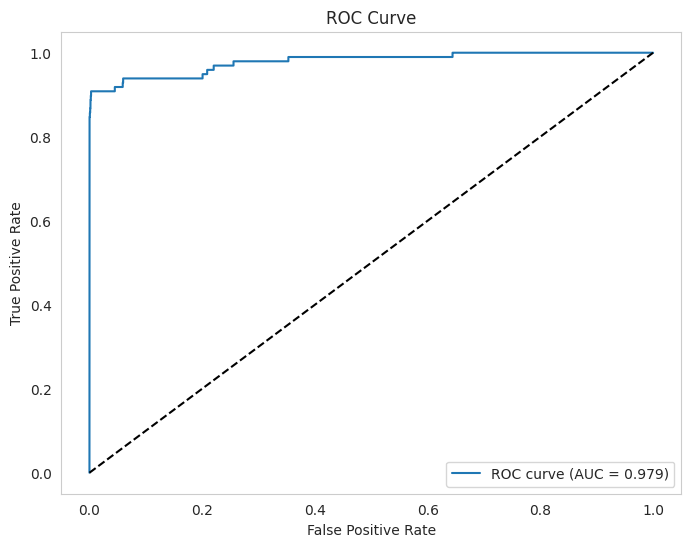

In [148]:
# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
auc = roc_auc_score(y_val, y_probs)

# Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')  # Línea diagonal (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

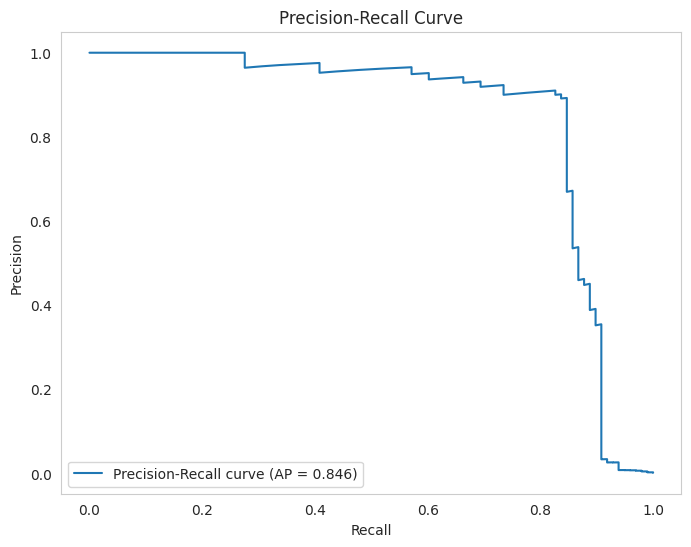

In [149]:
#Curva de Presicion Recall
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)
ap = average_precision_score(y_val, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

<p data-start="0" data-end="126">Las gr&aacute;ficas proporcionadas muestran el desempe&ntilde;o del modelo en t&eacute;rminos de discriminaci&oacute;n y precisi&oacute;n para la clase positiva:</p>
<ol data-start="128" data-end="639">
<li data-start="128" data-end="350">
<p data-start="131" data-end="350"><strong data-start="131" data-end="159">Curva ROC (AUC = 0.982):</strong> El modelo presenta una excelente capacidad para distinguir entre clases. Un AUC cercano a 1 indica que el modelo clasifica correctamente los positivos y negativos en la mayor&iacute;a de los casos.</p>
</li>
<li data-start="352" data-end="639">
<p data-start="355" data-end="639"><strong data-start="355" data-end="395">Curva Precision-Recall (AP = 0.836):</strong> El modelo mantiene un buen balance entre precisi&oacute;n y recall, lo cual es especialmente importante en contextos con clases desbalanceadas. Un AP (average precision) de 0.836 sugiere un buen desempe&ntilde;o general en la detecci&oacute;n de la clase positiva.</p>
</li>
</ol>
<p data-start="641" data-end="788">En resumen, ambas gr&aacute;ficas confirman que el modelo es eficaz en la detecci&oacute;n de la clase minoritaria, mostrando un rendimiento s&oacute;lido y confiable.</p>
<p>.</p>

### Buscando el mejor Threshold tomando como metrica F1

**Buscando el Mejor Threshold en los datos de validacion**

In [166]:
# Probabilidades predichas por el modelo
y_probs = best_model.predict(X_val_select) 
# Buscar el mejor threshold para F1-score
best_thresh, best_f1 = find_best_threshold(y_val, y_probs)
# Usar ese threshold para predecir clases
print(f"Mejor threshold: {best_thresh:.2f} con F1-score: {best_f1:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mejor threshold: 0.47 con F1-score: 0.8691


**Predicción con el conjunto de datos de Validacion**

In [167]:
y_pred = (y_probs >= best_thresh).astype(int)

In [168]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.89      0.85      0.87        98

    accuracy                           1.00     56961
   macro avg       0.95      0.92      0.93     56961
weighted avg       1.00      1.00      1.00     56961



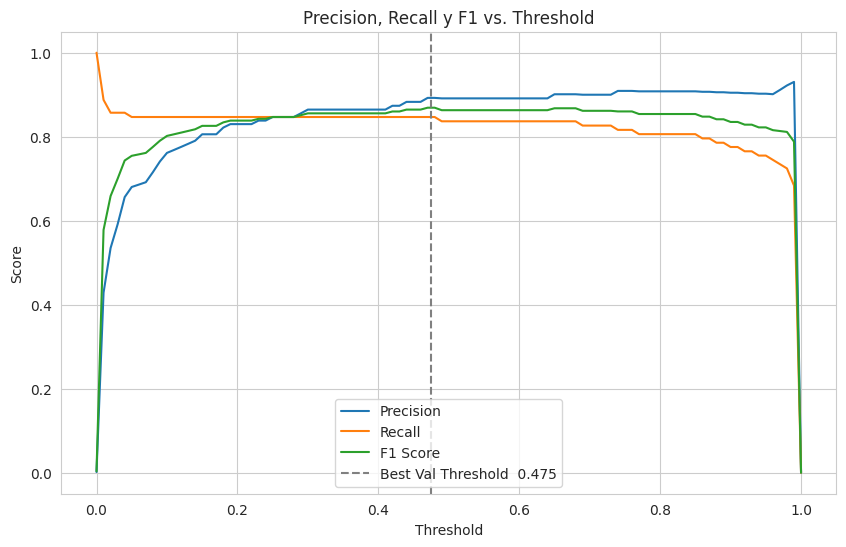

In [169]:
#Representar graficamente el threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precision_scores.append(precision_score(y_val, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline( best_thresh, color='gray', linestyle='--', label=f'Best Val Threshold  {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


**Buscando el Mejor Threshold en los datos de prueba**

In [156]:
# Probabilidades predichas por el modelo
y_probs = best_model.predict(X_test_select)
# Buscar el mejor threshold para F1-score
best_thresh2, best_f1 = find_best_threshold(y_test, y_probs)
# Usar ese threshold para predecir clases
print(f"Mejor threshold: {best_thresh2:.2f} con F1-score: {best_f1:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mejor threshold: 0.73 con F1-score: 0.8729


**Predicción con el conjunto de datos de Prueba**

In [157]:
y_pred = (y_probs >= best_thresh2).astype(int)

In [158]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.90      0.85      0.87        93

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



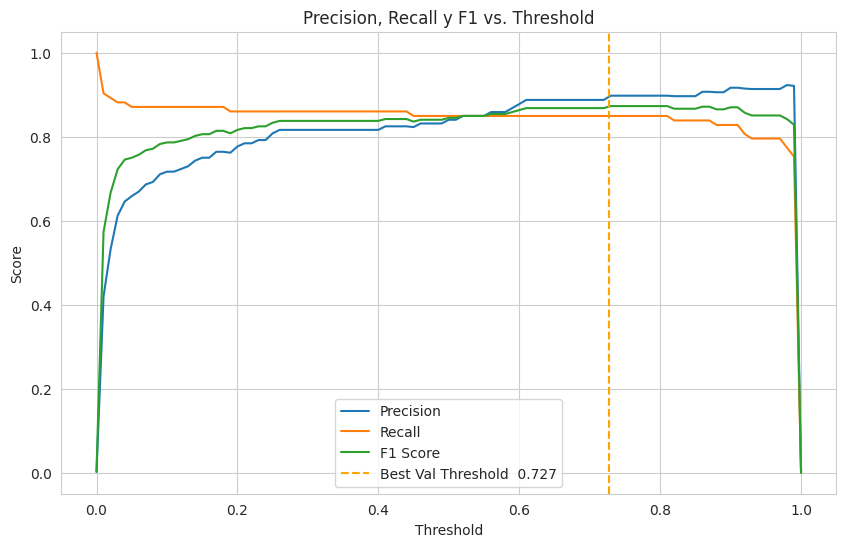

In [162]:
#Representar graficamente el threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh2, color='orange', linestyle='--', label=f'Best Val Threshold  {best_thresh2:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


<p data-start="91" data-end="389"><strong>Conclusi&oacute;n:</strong><br /><br />En la pr&aacute;ctica, se ha decidido mantener un umbral fijo en 0.5 para la clasificaci&oacute;n, dado que ambas gr&aacute;ficas &mdash;una del conjunto de validaci&oacute;n y otra del conjunto de prueba&mdash; muestran curvas casi planas en las m&eacute;tricas clave (precisi&oacute;n, recall y F1-score) en un amplio rango alrededor de este valor.</p>
<p data-start="391" data-end="699">Aunque el umbral &oacute;ptimo calculado para validaci&oacute;n (0.47) y prueba (0.727) difieren, la variaci&oacute;n en el desempe&ntilde;o es m&iacute;nima y no justifica un ajuste din&aacute;mico del umbral. Por lo tanto, usar 0.5 es una decisi&oacute;n razonable que facilita la implementaci&oacute;n sin sacrificar la estabilidad ni la efectividad del modelo.</p>
<p data-start="701" data-end="918">Este comportamiento se respalda con un AUC alto (0.979) y una curva Precision-Recall s&oacute;lida (AP = 0.836), confirmando que el modelo tiene una capacidad discriminativa robusta y consistente en ambos conjuntos de datos.</p>

## 7.- Guardar Modelo para uso posterior

In [135]:
import joblib

joblib.dump(best_model, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']